<a href="https://colab.research.google.com/github/nikJ13/micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def g(x):
    return 3*x**2 - 4*x + 5

In [ ]:
g(4.0)

37.0

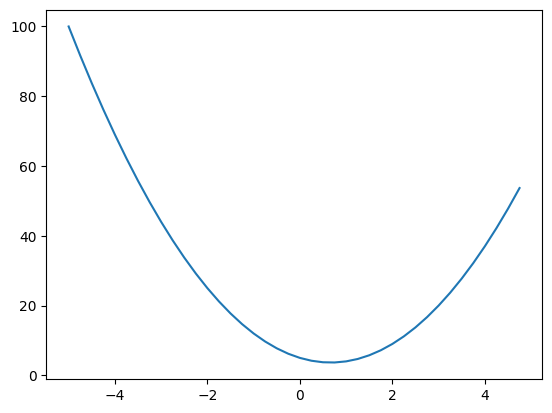

In [ ]:
xs = np.arange(-5,5,0.25)
ys = g(xs)
plt.plot(xs,ys)

In [ ]:
h = 0.00001
x = -3
(g(x+h) - g(x))/h

-21.999970000052823

In [ ]:
class Value:

  def __init__(self,data, _children = (), _op = '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda : None

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)  # suppose the other operand is an integer instead of a Value obj, then this line checks for it and wraps it within the Value obj
    output_val = Value(self.data + other.data, (self,other), "+")

    def _backward():
      #print('Im in add')
      self.grad += output_val.grad * 1  # here += is used because there are cases where the same nodes are used to perform different operations. Thus, during back propagation, different gradients are calculated for different outputs
      other.grad += output_val.grad * 1 # for the same two nodes. Hence, we do += so that all the gradients calculated for difference outputs from the two nodes are added instead.

    output_val._backward = _backward # pass by reference
    return output_val

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    output_val = Value(self.data * other.data, (self,other), "*")

    def _backward():
      #print('Im in mul')
      self.grad += output_val.grad * other.data
      other.grad += output_val.grad * self.data

    output_val._backward = _backward # pass by reference
    return output_val

  def __pow__(self,other):
    assert isinstance(other,(int,float) ), "only supporting int/float powers for now" # here, the power is forced to be an integer or a float
    output_val = Value(self.data**other,(self,),f'**{other}')

    def _backward():
      #print('Im in pow')
      self.grad += output_val.grad * (other * self.data**(other-1))

    output_val._backward = _backward
    return output_val


  def __rmul__(self,other): # for integer * Value obj
    return self * other     # this calls the __mul__ method, where the other (which is the integer) is defined as a Value obj

  def __truediv__(self,other): # for self / other
    return self * other**-1

  def __neg__(self): # for -self
    return self * -1

  def __sub__(self,other): # for self - other
    return self + (-other)

  def __radd__(self,other): # for integer + Value obj
    return self + other     # this calls the __add__ method, where the other (which is the integer) is defined as a Value obj

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    output_val = Value(t, (self, ), 'tanh')

    def _backward():
      #print('Im in tanh')
      self.grad = (1-t**2) * output_val.grad

    output_val._backward = _backward # pass by reference; so the backward function of the current node is being pointed by the next node

    return output_val

  def exp(self):
    x = self.data
    output_val = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      #print('Im in exp')
      self.grad += output_val.grad * output_val.data

    output_val._backward = _backward # pass by reference; so the backward function of the current node is being pointed by the next node

    return output_val

  def backward(self):

    # performing topological sort so that back propagation works in the order of the nodes placed
    topo = []
    visit = set()
    def build_topo(node):
      if node not in visit:
        visit.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)

    build_topo(self)
    self.grad = 1
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2,label = "a") #input val
b = Value(-3, label = "b") #input val
c = Value(10, label = "c") #input val
a + b # executes a.__add__(b)
a*b # executes a.__mul__(b)

Here, backpropagation works in the following manner: When control is on a node, then it calls the backward function of its immediate previous nodes. That ways when the control shifts to the immediate previous nodes, then the gradients of those nodes would already be calculated, thus calling the backward function of those that are previous to them also, thereby implementing backpropagation.

In [ ]:
q = Value(9)
p = Value(3)
q + p
q*p + p*q
1 + p

Value(data = 4)

In [ ]:
e = a*b
e.label = "e"
d = e + c
d.label = "d"
d
f = Value(-2,label="f") #input val
L = d*f; L.label = "L"
L

Value(data = -8)

In [ ]:
d._prev

{Value(data = -6), Value(data = 10)}

In [ ]:
d._op #prints the mathematical expression that gives the value for d

'+'

In [ ]:
d.label

'd'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      # if this value is a result of some operation, create an operation node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect the op node to the value node
      dot.edge(uid+n._op, uid)

  for n1,n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)),str(id(n2))+n2._op)

  return dot


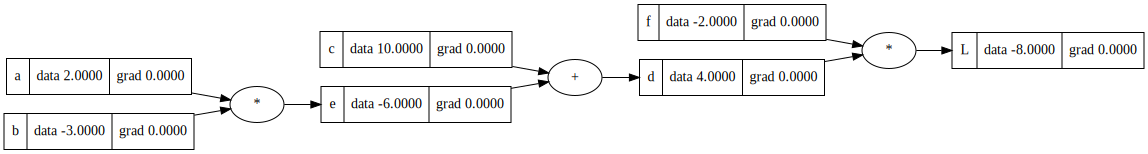

In [ ]:
draw_dot(L)

In [ ]:
'''The above example is an implementation of a function taking multiple inputs, with the expression as F (function) = a*b + c. Here, we are calculating a loss function L in the end as L = F*f = (a*b +c)*f. This can be visualised
as a small scale simulation of a NN, where a,b,c and f are the inputs, which act as the weights of the NN (if you ignore the arithmetic signs). Here, L can be thought of as a Loss Function calculated from the output of the NN, d.

So, backpropagation is basically calculating the change in L when there is a change in a,b,c and f. For this, we calculate the derivative of
L with respect to a,b,c and f, thereby obtaining the derivatives of L with respect to the weights of the NN. Hence, the weights can accordingly
changed to minimise the loss function.'''


'The above example is an implementation of a function taking multiple inputs, with the expression as F (function) = a*b + c. Here, we are calculating a loss function L in the end as L = F*f = (a*b +c)*f. This can be visualised\nas a small scale simulation of a NN, where a,b,c and f are the inputs, which act as the weights of the NN (if you ignore the arithmetic signs). Here, L can be thought of as a Loss Function calculated from the output of the NN, d.\n\nSo, backpropagation is basically calculating the change in L when there is a change in a,b,c and f. For this, we calculate the derivative of\nL with respect to a,b,c and f, thereby obtaining the derivatives of L with respect to the weights of the NN. Hence, the weights can accordingly\nchanged to minimise the loss function.'

In [ ]:
def lol():

  h = 0.00001

  a = Value(2,label = "a") #input val
  b = Value(-3, label = "b") #input val
  c = Value(10, label = "c") #input val
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2,label="f") #input val
  L = d*f; L.label = "L"
  L1 = L.data

  a = Value(2+h,label = "a") #input val
  b = Value(-3, label = "b") #input val
  c = Value(10, label = "c") #input val
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2,label="f") #input val
  L = d*f; L.label = "L"
  L2 = L.data

  print((L2-L1)/h)

In [ ]:
#derivative of L with respect to 'a'
lol()

6.000000000128124


# Executing backpropagation on a neuron

Using the backward function integrated in the Value class

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias
b = Value(6.8813735870195432, label = "b")

# x1w1 + x2w2 + b
x1w1 = x1*w1;x1w1.label = "x1w1"
x2w2 = x2*w2;x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
output = n.tanh(); output.label = "output"
output.backward()

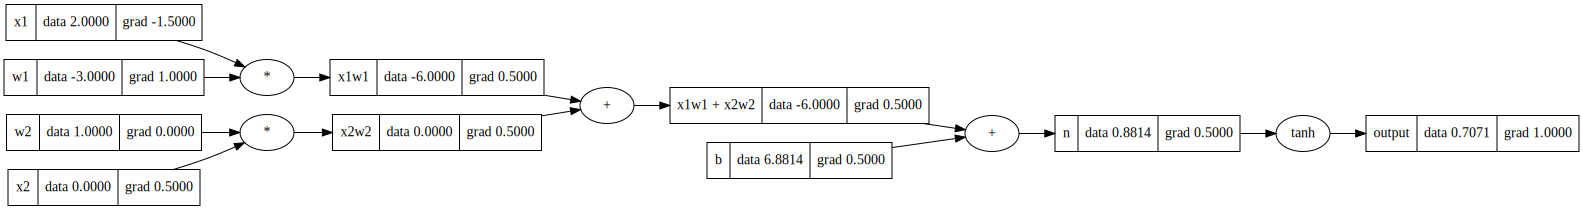

In [ ]:
draw_dot(output)

### Manually

In [ ]:
#d(output)/d(output) = 1
output.grad = 1.0

In [ ]:
# output = tanh(n); d(output)/dn = 1 - tanh(n)**2 = 1 - output**2
n.grad = 1 - output.data**2

In [ ]:
# d(output)/db = d(output)/dn * dn/db = (1-output**2) * 1
b.grad = n.grad * 1

In [ ]:
# d(output)/d(x1w1 + x2w2) = d(output)/dn * dn/d(x1w1 + x2w2) = (1-output**2) * 1
x1w1x2w2.grad = n.grad * 1

In [ ]:
# d(output)/d(x1w1) = d(output)/d(x1w1 + x2w2) * d(x1w1 + x2w2)/d(x1w1) = (1-output**2) * 1
#similar case for x2w2 grad
x1w1.grad = x1w1x2w2.grad * 1
x2w2.grad = x1w1x2w2.grad * 1

In [ ]:
# n = x1w1 + x2w2 + b; d(output)/dw1 = d(output)/dn * dn/dw1 = (1 - output**2) * x1
# d(output)/dw2 = d(output)/dn * dn/dw2 = (1-output**2) * x2
w1.grad = n.grad * x1.data
w2.grad = n.grad * x2.data

In [ ]:
# d(output)/dx1 = d(output)/dn * dn/dx1 = (1-output**2) * w1
# d(output)/dx2 = d(output)/dn * dn/dx2 = (1-output**2) * w2
x1.grad = n.grad * w1.data
x2.grad = n.grad * w2.data

### Using the Value object

In [ ]:
output.grad = 1

In [ ]:
# if we execute this
output._backward
# output below shows the details of the reference pointer to the _backward method

<function __main__.Value.tanh.<locals>._backward()>

In [ ]:
output._backward()
# in the Value class, since the _backward is a class attribute, which is a lambda function; hence, this class attribute is executed using the above statement

Im in tanh


In [ ]:
n._backward()

Im in add


In [ ]:
b._backward # since b has no children at the back, hence, the location of the backward method is within the class initialisation, which in this case is lmabda : None

<function __main__.Value.__init__.<locals>.<lambda>()>

In [ ]:
x1w1x2w2._backward()

Im in add


In [ ]:
x1w1._backward()

Im in mul


In [ ]:
x2w2._backward()

Im in mul


Using the exponent, division and power functions in the Value class

Im in tanh
Im in add
Im in add
Im in mul
Im in mul


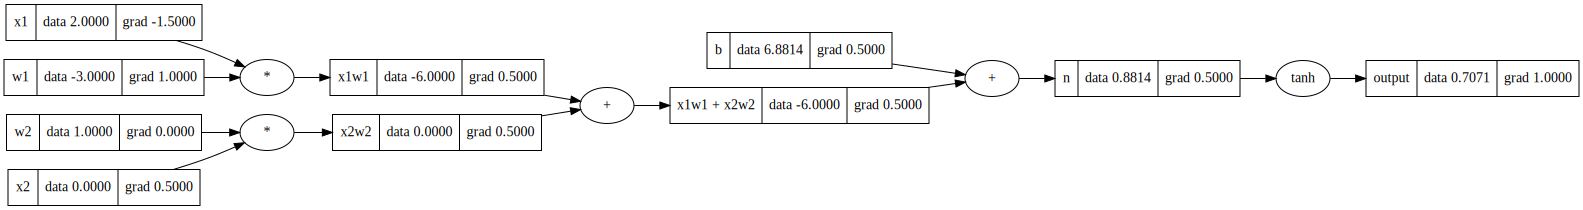

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias
b = Value(6.8813735870195432, label = "b")

# x1w1 + x2w2 + b
x1w1 = x1*w1;x1w1.label = "x1w1"
x2w2 = x2*w2;x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

#----
e = (2*n).exp()
output = (e-1)/(e+1)
output = n.tanh()
output.label = "output"

#----
output.backward()
draw_dot(output)

### Using Pytorch to carry out the above operation

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o.data.item()

0.7071066904050358

In [ ]:
w1.grad

tensor([1.0000], dtype=torch.float64)

#### Building a Neural Net from scratch

In [ ]:
# showing an example of how one can call an object as a method using the built in __call__ method
class Example:
  def __init__(self,nin): # here, nin refers to number of inputs to this neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    # x is a list of inputs
    return 0

x = [5,6]
nn = Example(2)
nn(x)  # this is as good as invoking nn.__call__(x)
#nn.__call__(x)
#################

0

In [ ]:
class Neuron:
  def __init__(self,nin): # here, nin refers to number of inputs to this neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x): # when called performs the activation operation for the particular neuron
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
    out = act.tanh()
    return out

  def parameters(self): # consolidating all the input parameters, such as the weights and the biases
    return self.w + [self.b]

class Layer:

  def __init__(self,nin,nout): # here, nin refers to number of inputs to each neuron in the layer and nout refers to the number of neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)] #initialising each neuron in the layer

  def __call__(self,x): # when called calls the operation to perform activation operations for all the neurons in the layer
    outs = [n(x) for n in self.neurons] # carrying out the activation function operation for the given input 'x' for each neuron in the layer and finally storing it in a list
    return outs[0] if len(outs)==1 else outs

  def parameters(self): # consolidating all the weights and biases of each neuron in the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin,nouts): # here, nin refers to the number of neurons in the input layer and nouts is the list of the sizes for each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # making the list which stores layer objects as its elements

  def __call__(self,x): # when called calls the operation to open each layer and perform the activation function operations in each neuron
    for layer in self.layers:
      x = layer(x) #sequentially calling each layer of the MLP
    return x

  def parameters(self): # consolidating all the weights and biases of each neuron, iterating through each layer
    return [p for layer in self.layers for p in layer.parameters()]

### General Information about Python

In [ ]:
# how zip works
a = [1,2,3,4,5]
b = [0,9,8,7,6]
print(list(zip(a,b)))
# here, zip becomes an iterator, that iterates on tuples consisting of the values of the lists passed as parameters, in the existing order

[(1, 0), (2, 9), (3, 8), (4, 7), (5, 6)]


### Continuing the Pytorch implementation

In [ ]:
# First implementation
input = [2,3,-1]
n = MLP(3,[4,4,1])
n(input)

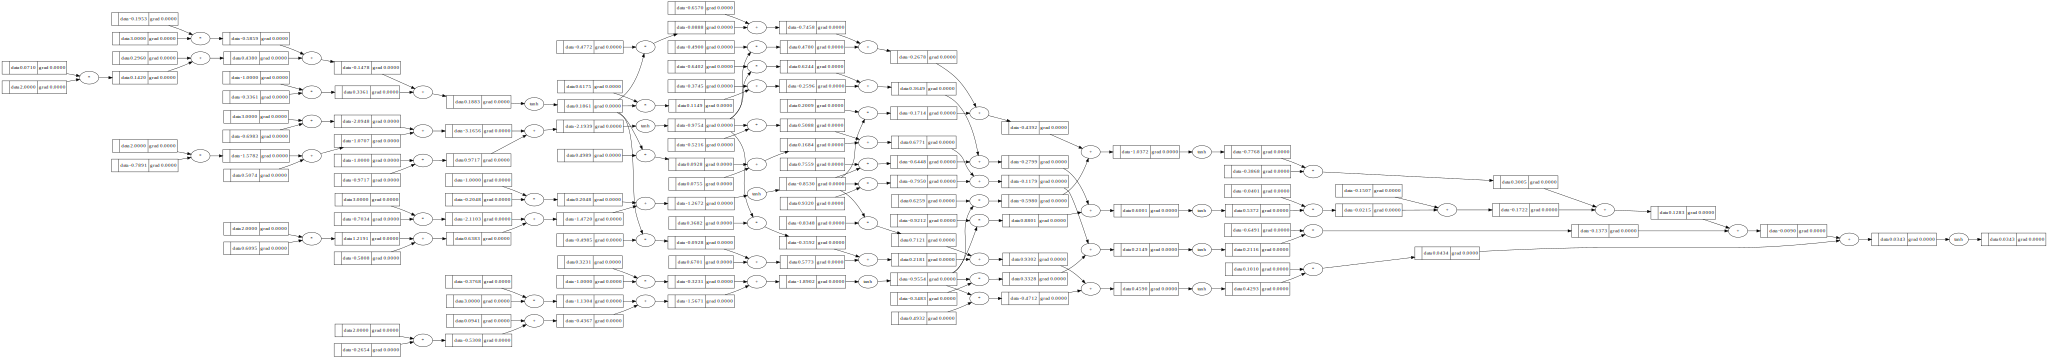

In [ ]:
draw_dot(n(input))

In [ ]:
# Running a binary classifier NN
xs = [
    [2,3,-1],  # each sub list inside the xs list is the input for the NN
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # each sublist input above has its corresponding desired output

n = MLP(3,[4,4,1])
ypred = [n(x) for x in xs] # predicted y output by the NN
ypred

[Value(data = 0.8931538176872622),
 Value(data = 0.9475877888942322),
 Value(data = 0.723795361556083),
 Value(data = 0.9458929070011027)]

In [ ]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs] # predicted y output by the NN

  # calculate the error from the desired values using the loss function (here, using squared error)
  loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])

  # zeroing out the gradients because if they are not zeroed out, then the gradients would keep accumulating, thereby giving a larger step size
  # (greater modification to the weights and biases) thereby overfitting the model on the desired outputs
  for p in n.parameters():
    p.grad = 0

  # performing backpropagation
  loss.backward()

  # updating the weights and the biases based on the gradients calculated for each of them during backpropagation
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k,loss)

0 Value(data = 0.007803195478133449)
1 Value(data = 0.007786902374309641)
2 Value(data = 0.0077706744538295)
3 Value(data = 0.007754511332401669)
4 Value(data = 0.0077384126287262205)
5 Value(data = 0.007722377964465949)
6 Value(data = 0.007706406964217436)
7 Value(data = 0.007690499255483209)
8 Value(data = 0.007674654468643445)
9 Value(data = 0.007658872236928476)
10 Value(data = 0.007643152196391553)
11 Value(data = 0.007627493985881825)
12 Value(data = 0.0076118972470175204)
13 Value(data = 0.007596361624159789)
14 Value(data = 0.007580886764386473)
15 Value(data = 0.007565472317466332)
16 Value(data = 0.0075501179358336695)
17 Value(data = 0.007534823274562993)
18 Value(data = 0.007519587991344197)
19 Value(data = 0.00750441174645787)


In [ ]:
ypred

[Value(data = 0.965624775188247),
 Value(data = -0.9594226697253314),
 Value(data = -0.9521660954403258),
 Value(data = 0.9511312624681612)]

### NOTE REGARDING CHANGING THE WEIGHTS AND BIASES OF THE NN:
Changing all the weights and biases by the gradient calculated for each of it; Here, since the gradient vector always points towards maximum increase of a function (in this case, the function is the error function), thus to obtain the minima of the error function, the weights and the biases must be changed in opposite sign of the gradient. Hence the equation:

new_weight = old_weight - 0.01*(gradient of that weight wrt the error function)

holds valid to calculate the new weights and biases of the NN.

Hence, this is equal to:

p.data = p.data - 0.01*p.grad

where the variables in this equation means the ones in the above equation

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad